**Predicting Pathologies In X-Ray Images**  *--work in progress--*

The NIH Clinical Center recently released over 100,000 anonymized chest x-ray images and their corresponding data to the scientific community. The release will allow researchers across the country and around the world to freely access the datasets and increase their ability to teach computers how to detect and diagnose disease. Ultimately, this artificial intelligence mechanism can lead to clinicians making better diagnostic decisions for patients.   

https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

https://stanfordmlgroup.github.io/projects/chexnet/

In [1]:
import pandas as pd
import numpy as np
import os
os.sys.path
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.
/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alan/miniconda2/envs/tfl/l

Load the data

In [2]:
PATH = os.path.abspath(os.path.join('/media/alan/4039-01DB/data_xray/images_001')) 
SOURCE_IMAGES = os.path.join(PATH, "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

images[0:10]
# images = images[0:90000]

[]

In [3]:
labels = pd.read_csv('/media/alan/4039-01DB/data_xray/Data_Entry_2017.csv')
labels.head(10)

FileNotFoundError: [Errno 2] File b'/media/alan/4039-01DB/data_xray/Data_Entry_2017.csv' does not exist: b'/media/alan/4039-01DB/data_xray/Data_Entry_2017.csv'

Plot a representative image

It should be noted that these images require some significant pre-processing and/or relabeling for best results.  For this exercise we will do only minimal pre-processing of the images.  See the following blogpost for more detail about specific challenges associated with this dataset: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/. 

What types of ailments are identified in these annotated X-ray images?

Convert annotated .png images into labeled numpy arrays.  Discard all images with more than one pathology.

In [4]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]

In [2]:

img_size = 79

def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 4
    Emphysema="Emphysema" #5
    Fibrosis="Fibrosis" #6
    Effusion="Effusion" #7
    Pneumonia="Pneumonia" #8
    Pleural_Thickening="Pleural_Thickening" #9
    Cardiomegaly="Cardiomegaly" #10
    NoduleMass="Nodule" #11
    Hernia="Hernia" #12
    Atelectasis="Atelectasis"  #13 
   # RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    i=0
    for img in images:
        i+=1
        base = os.path.basename(img)
        # Read and resize image
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if i % 1000 == 0:
                print("Iteration", i)
        if symbol in finding:
            images.remove(img)
        elif NoFinding in finding:
            if (np.random.uniform(0,1,1)>0.75):
                images.remove(img)
        elif Infiltration in finding:
            if (np.random.uniform(0,1,1)>0.75):
                images.remove(img)
        elif Effusion in finding:
            if (np.random.uniform(0,1,1)>0.75):
                images.remove(img)
        else:
            continue
    return 

In [6]:
proc_images()
len(images)

Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000
Iteration 30000
Iteration 31000
Iteration 32000
Iteration 33000
Iteration 34000
Iteration 35000
Iteration 36000
Iteration 37000
Iteration 38000
Iteration 39000
Iteration 40000
Iteration 41000
Iteration 42000
Iteration 43000
Iteration 44000
Iteration 45000
Iteration 46000
Iteration 47000
Iteration 48000
Iteration 49000
Iteration 50000
Iteration 51000
Iteration 52000
Iteration 53000
Iteration 54000
Iteration 55000
Iteration 56000
Iteration 57000
Iteration 58000
Iteration 59000
Iteration 60000
Iteration 61000
Iteration 62000
Iteration 63000
I

83235

In [12]:
import pickle
# Save and load the X and y from previous times.
with open('images_path_singlelabel.pickle', 'wb') as f:
    pickle.dump([images], f)

In [23]:

img_size = 256

def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 4
    Emphysema="Emphysema" #5
    Fibrosis="Fibrosis" #6
    Effusion="Effusion" #7
    Pneumonia="Pneumonia" #8
    Pleural_Thickening="Pleural_Thickening" #9
    Cardiomegaly="Cardiomegaly" #10
    NoduleMass="Nodule" #11
    Hernia="Hernia" #12
    Atelectasis="Atelectasis"  #13 
   # RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = img_size
    HEIGHT = img_size
    a0=0;a1=0;a2=0;a3=0;a4=0;a5=0;a6=0;a7=0;a8=0;a9=0;a10=0;a11=0;a12=0;a13=0;i=0;
    num_imgs = 200
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if a0+a1+a2+a3+a4+a5+a6+a7+a8+a9+a10+a11+a12+a13 == (num_imgs-1)*14:
            break
        if i % 5000 == 0:
                print("Iteration", i)
        if symbol in finding:
            continue
        else:
            if NoFinding in finding:
                finding = 0
                if a0 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a0+=1
            elif Consolidation in finding:
                finding = 1
                if a1 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a1+=1
            elif Infiltration in finding:
                finding = 2
                if a2 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a2+=1
            elif Pneumothorax in finding:
                finding = 3
                if a3 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a3+=1
            elif Edema in finding:
                finding = 4
                if a4 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a4+=1
            elif Emphysema in finding:
                finding = 5
                if a5 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a5+=1
            elif Fibrosis in finding:
                finding = 6
                if a6 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a6+=1
            elif Effusion in finding:
                finding = 7
                if a7 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a7+=1
            elif Pneumonia in finding:
                finding = 8
                if a8 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a8+=1
            elif Pleural_Thickening in finding:
                finding = 9
                if a9 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a9+=1
            elif Cardiomegaly in finding:
                finding = 10
                if a10 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a10+=1
            elif NoduleMass in finding:
                finding = 11
                if a11 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a11+=1
            elif Hernia in finding:
                finding = 12
                if a12 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a12+=1
            elif Atelectasis in finding:
                finding = 13
                if a13 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(cv2.imread(img), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a13+=1
            else:
                continue
        i+=1
    return x,y

In [ ]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000


In [7]:
df['labels'].value_counts()

13    300
11    300
7     300
3     300
2     300
0     300
1     245
9     208
10    187
6     148
5     143
4     109
8      50
12     15
Name: labels, dtype: int64

In [3]:
import pickle
# Save and load the X and y from previous times.
# with open('newSampleXy128x128-diseasesOnly.pickle', 'rb') as f:
#     X, y = pickle.load(f)  
# with open('newSampleXy79x79-200imgs.pickle', 'rb') as f:
#     X, y = pickle.load(f)  
# with open('newSampleXy100x100-diseasesOnly.pickle', 'rb') as f:
#     X, y = pickle.load(f)
# with open('newSampleXy79x79-fulldata.pickle', 'rb') as f:
#     X, y = pickle.load(f)
# with open('newSampleXy128x128-1000each.pickle', 'rb') as f:
#     X, y = pickle.load(f)
with open('newSampleXy-79x79-100each.pickle', 'rb') as f:
    X, y = pickle.load(f)  

df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)

1400 (79, 79, 3)


Describe new numpy arrays

In [4]:
# dict_characters = {0: 'Consolidation', 1: 'Infiltration', 2: 'Pneumothorax', 3: 'Edema', 
#                    4: 'Emphysema', 5: 'Fibrosis', 6: 'Effusion', 7: 'Pneumonia', 
#                    8: 'Pleural Thickening', 9: 'Cardiomegaly', 10: "Nodule Mass", 11: 'Hernia', 
#                    12: "Atelectasis"}
dict_characters = {0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural Thickening', 10: 'Cardiomegaly', 11: "Nodule Mass", 12: 'Hernia', 13: "Atelectasis"}

print(df.head(15))
print("")
print(dict_characters)

                                               images  labels
0   [[[176, 176, 176], [30, 30, 30], [0, 0, 0], [0...      10
1   [[[67, 67, 67], [63, 63, 63], [72, 72, 72], [8...       0
2   [[[25, 25, 25], [11, 11, 11], [11, 11, 11], [1...      12
3   [[[31, 31, 31], [19, 19, 19], [17, 17, 17], [1...      12
4   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      12
5   [[[77, 77, 77], [68, 68, 68], [68, 68, 68], [6...      12
6   [[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...      12
7   [[[19, 19, 19], [2, 2, 2], [2, 2, 2], [4, 4, 4...      12
8   [[[59, 59, 59], [13, 13, 13], [6, 6, 6], [7, 7...      12
9   [[[28, 28, 28], [15, 15, 15], [12, 12, 12], [1...       0
10  [[[89, 89, 89], [75, 75, 75], [61, 61, 61], [5...       0
11  [[[3, 3, 3], [3, 3, 3], [3, 3, 3], [2, 2, 2], ...       0
12  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
13  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
14  [[[6, 6, 6], [6, 6, 6], [6, 6, 6], [6, 6, 6], ...       0

{0: 'No

Describe the distribution of pixel intensities within a representative image

Normalize the pixel intensities between zero and one.

In [5]:
# Make the input a Numpy array, and normalize it by max pixel intensity.
X=np.array(X)
X=X/255.0
# import tensorflow as tf
# tf.image.per_image_standardization(X)

Describe distribution of class labels

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}
13    100
12    100
11    100
10    100
9     100
8     100
7     100
6     100
5     100
4     100
3     100
2     100
1     100
0     100
Name: labels, dtype: int64


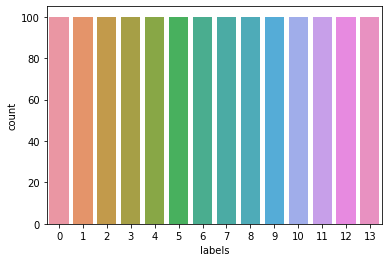

In [6]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
print(dist)

We have imbalanced sample sizes.  This is a problem that needs to be addressed.

But for now we can proceed with a preliminary analysis.

In [7]:
# Split train and test sets.

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

# Reduce Sample Size for DeBugging
# X_train = X_train[0:5000] 
# Y_train = Y_train[0:5000]
# X_test = X_test[0:2000] 
# Y_test = Y_test[0:2000]

In [8]:
del X, y, df #free up some memory.

In [9]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (980, 79, 79, 3)
Testing Data Shape: (420, 79, 79, 3)
Training Data Shape: 980 (79, 79, 3)
Testing Data Shape: 420 (79, 79, 3)


Now I will try to use a vanilla CNN to predict each ailment based off of the X-Ray image.

In [10]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 14)
Y_testHot = to_categorical(Y_test, num_classes = 14)

In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes.  In this case the class_weights parameter will eventually be passed to the model.fit function.

In [11]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
# print(class_weight)
# class_weight = 14*[1]
print(class_weight)

[1.16666667 0.98591549 1.01449275 1.02941176 0.90909091 0.98591549
 1.         0.90909091 1.01449275 0.98591549 0.93333333 0.97222222
 1.06060606 1.09375   ]


In [12]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve(history):
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = history.history['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.test.gpu_device_name()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5075168471269890568
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 398335804167857710
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16097237190821074549
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1547304960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5078186746162694374
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


'/device:GPU:0'

In [14]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [15]:
# from numba import jit, cuda 
# # function optimized to run on gpu  
# @jit(target ="cuda") 
from keras.layers import GlobalAveragePooling2D
with tf.device('/device:GPU:0'):

    def runCNNconfusion(a,b,c,d,e,f,g,h):
        # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
        batch_size = 10
        num_classes = f
        epochs = g
        #img_rows, img_cols = X_train.shape[1],b.shape[2]
        input_shape = (img_size, img_size, 3)
        model = Sequential()
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu', input_shape = input_shape,strides=h))
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1024, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.0)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(64, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.0)))
        model.add(Dropout(0.25))
        model.add(Dense(num_classes, activation = "softmax"))
        # Define the optimizer
        optimizer = Adam(lr=0.01)
        model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rescale=1. / 255, #rescale
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        datagen.fit(a)
        history = model.fit_generator(datagen.flow(a,b, batch_size=10),
                            steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  
                                      validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
        model.summary()
#         history = model.fit(a,b, epochs=epochs, class_weight=e, batch_size = batch_size,
#                             validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0) 
        print('\nKeras Vanilla CNN - accuracy:', score[1],'\n')
        Y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
        Y_pred_classes = np.argmax(Y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1) 
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
        plt.show()
        return model, history
model, history = runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,13,50,1)
plot_learning_curve(history)
plt.show()
plotKerasLearningCurve(history)
plt.show()



Epoch 1/50
607/606 [==============================] - 116s 191ms/step - loss: 2.4780 - accuracy: 0.1936 - val_loss: 11745.0140 - val_accuracy: 0.0906
Epoch 2/50
607/606 [==============================] - 56s 92ms/step - loss: 2.2304 - accuracy: 0.2010 - val_loss: 42302.0584 - val_accuracy: 0.0906
Epoch 3/50
607/606 [==============================] - 56s 92ms/step - loss: 2.2276 - accuracy: 0.1942 - val_loss: 43014.8735 - val_accuracy: 0.0906
Epoch 4/50
607/606 [==============================] - 56s 92ms/step - loss: 2.2446 - accuracy: 0.1944 - val_loss: 43438.2649 - val_accuracy: 0.0906
Epoch 5/50
607/606 [==============================] - 56s 92ms/step - loss: 2.2261 - accuracy: 0.2076 - val_loss: 44142.9551 - val_accuracy: 0.0906
Epoch 6/50
607/606 [==============================] - 56s 92ms/step - loss: 2.2395 - accuracy: 0.1942 - val_loss: 63297.2141 - val_accuracy: 0.0906
Epoch 7/50
607/606 [==============================] - 56s 92ms/step - loss: 2.2249 - accuracy: 0.2066 - val_

KeyboardInterrupt: 

In [31]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_CNN.h5")
print("Saved model to disk")
 


Saved model to disk


In [37]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.fit(X_train,Y_trainHot, epochs=100, class_weight=class_weight, batch_size = 10,
                            validation_data=(X_test,Y_testHot), verbose=1,callbacks = [MetricsCheckpoint('logs')])
# score = loaded_model.evaluate(X, y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk
Train on 8175 samples, validate on 3504 samples
Epoch 1/100
8175/8175 [==============================] - 61s 7ms/step - loss: 2.3155 - accuracy: 0.2210 - val_loss: 2.4333 - val_accuracy: 0.1821
Epoch 2/100
8175/8175 [==============================] - 63s 8ms/step - loss: 2.3243 - accuracy: 0.2148 - val_loss: 2.3547 - val_accuracy: 0.2072
Epoch 3/100
8175/8175 [==============================] - 63s 8ms/step - loss: 2.3216 - accuracy: 0.2144 - val_loss: 2.4211 - val_accuracy: 0.1826
Epoch 4/100
8175/8175 [==============================] - 63s 8ms/step - loss: 2.3188 - accuracy: 0.2190 - val_loss: 2.3486 - val_accuracy: 0.2069
Epoch 5/100
8175/8175 [==============================] - 62s 8ms/step - loss: 2.3173 - accuracy: 0.2159 - val_loss: 2.5433 - val_accuracy: 0.1610
Epoch 6/100
8175/8175 [==============================] - 64s 8ms/step - loss: 2.3183 - accuracy: 0.2143 - val_loss: 2.5088 - val_accuracy: 0.1735
Epoch 7/100
8175/8175 [==============================

KeyboardInterrupt: 

In [15]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess
# from tensorflow.v1 import ConfigProto
# from tensorflow.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6864416466928320855
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16188865283982699463
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14591045856191284591
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1570504704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12430948907066180109
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 79, 79, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 79, 79, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 79, 79, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 39, 39, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 39, 39, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 39, 39, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 19, 19, 128)       0   

Epoch 89/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1294 - accuracy: 0.3196 - val_loss: 2.4939 - val_accuracy: 0.1929
Epoch 90/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1157 - accuracy: 0.3054 - val_loss: 2.5208 - val_accuracy: 0.1714
Epoch 91/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1262 - accuracy: 0.3223 - val_loss: 2.5011 - val_accuracy: 0.1643
Epoch 92/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1189 - accuracy: 0.3179 - val_loss: 2.5279 - val_accuracy: 0.1714
Epoch 93/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1193 - accuracy: 0.3125 - val_loss: 2.4878 - val_accuracy: 0.1964
Epoch 94/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1062 - accuracy: 0.3259 - val_loss: 2.4758 - val_accuracy: 0.1679
Epoch 95/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 2.1017 - accuracy: 0.3268 - val_loss: 2

1120/1120 [==============================] - 8s 7ms/step - loss: 1.6865 - accuracy: 0.4598 - val_loss: 2.6025 - val_accuracy: 0.1786
Epoch 200/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.6649 - accuracy: 0.4598 - val_loss: 2.6227 - val_accuracy: 0.1857
Epoch 201/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.6784 - accuracy: 0.4598 - val_loss: 2.5926 - val_accuracy: 0.1857
Epoch 202/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.6648 - accuracy: 0.4750 - val_loss: 2.5567 - val_accuracy: 0.1821
Epoch 203/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.6503 - accuracy: 0.4705 - val_loss: 2.4995 - val_accuracy: 0.1893
Epoch 204/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.6227 - accuracy: 0.4955 - val_loss: 2.5809 - val_accuracy: 0.1857
Epoch 205/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.6700 - accuracy: 0.4688 - val_loss: 2.5348 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 1.2810 - accuracy: 0.6089 - val_loss: 2.6704 - val_accuracy: 0.2036
Epoch 310/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.3117 - accuracy: 0.5893 - val_loss: 2.8768 - val_accuracy: 0.1679
Epoch 311/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.2487 - accuracy: 0.6027 - val_loss: 2.7526 - val_accuracy: 0.1929
Epoch 312/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.2586 - accuracy: 0.6080 - val_loss: 2.9100 - val_accuracy: 0.1893
Epoch 313/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.2350 - accuracy: 0.6089 - val_loss: 2.8802 - val_accuracy: 0.1679
Epoch 314/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.2396 - accuracy: 0.6232 - val_loss: 2.7195 - val_accuracy: 0.2036
Epoch 315/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 1.2585 - accuracy: 0.6152 - val_loss: 2.7451 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 0.8206 - accuracy: 0.7554 - val_loss: 3.0982 - val_accuracy: 0.1893
Epoch 420/1000
1120/1120 [==============================] - 7s 7ms/step - loss: 0.9152 - accuracy: 0.7009 - val_loss: 3.0364 - val_accuracy: 0.1929
Epoch 421/1000
1120/1120 [==============================] - 7s 7ms/step - loss: 0.8520 - accuracy: 0.7545 - val_loss: 3.0704 - val_accuracy: 0.1857
Epoch 422/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.8413 - accuracy: 0.7491 - val_loss: 3.3049 - val_accuracy: 0.1714
Epoch 423/1000
1120/1120 [==============================] - 7s 6ms/step - loss: 0.8360 - accuracy: 0.7616 - val_loss: 3.3107 - val_accuracy: 0.1714
Epoch 424/1000
1120/1120 [==============================] - 7s 6ms/step - loss: 0.8332 - accuracy: 0.7679 - val_loss: 3.0818 - val_accuracy: 0.1786
Epoch 425/1000
1120/1120 [==============================] - 7s 6ms/step - loss: 0.8361 - accuracy: 0.7688 - val_loss: 3.1518 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 0.5291 - accuracy: 0.8562 - val_loss: 3.3108 - val_accuracy: 0.2143
Epoch 530/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.4852 - accuracy: 0.8750 - val_loss: 3.2576 - val_accuracy: 0.1929
Epoch 531/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.5894 - accuracy: 0.8161 - val_loss: 4.2950 - val_accuracy: 0.1571
Epoch 532/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.5869 - accuracy: 0.8518 - val_loss: 3.6144 - val_accuracy: 0.2000
Epoch 533/1000
1120/1120 [==============================] - 7s 7ms/step - loss: 0.5545 - accuracy: 0.8411 - val_loss: 3.3631 - val_accuracy: 0.1893
Epoch 534/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.5669 - accuracy: 0.8473 - val_loss: 3.2905 - val_accuracy: 0.2071
Epoch 535/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.5153 - accuracy: 0.8571 - val_loss: 3.4238 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 0.3341 - accuracy: 0.9232 - val_loss: 3.7738 - val_accuracy: 0.1964
Epoch 640/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.2385 - accuracy: 0.9634 - val_loss: 3.6484 - val_accuracy: 0.2036
Epoch 641/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.1927 - accuracy: 0.9857 - val_loss: 3.9499 - val_accuracy: 0.1821
Epoch 642/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.1932 - accuracy: 0.9875 - val_loss: 3.7564 - val_accuracy: 0.2000
Epoch 643/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.1838 - accuracy: 0.9839 - val_loss: 3.6459 - val_accuracy: 0.2071
Epoch 644/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.2058 - accuracy: 0.9732 - val_loss: 3.6332 - val_accuracy: 0.2179
Epoch 645/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.1736 - accuracy: 0.9911 - val_loss: 3.6879 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 0.0753 - accuracy: 1.0000 - val_loss: 4.0404 - val_accuracy: 0.1964
Epoch 750/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0752 - accuracy: 1.0000 - val_loss: 4.0369 - val_accuracy: 0.2179
Epoch 751/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0757 - accuracy: 1.0000 - val_loss: 4.0606 - val_accuracy: 0.2071
Epoch 752/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 4.1107 - val_accuracy: 0.2000
Epoch 753/1000
1120/1120 [==============================] - 7s 7ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 4.0366 - val_accuracy: 0.2107
Epoch 754/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0773 - accuracy: 1.0000 - val_loss: 4.0112 - val_accuracy: 0.2036
Epoch 755/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0733 - accuracy: 1.0000 - val_loss: 4.0152 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 4.3260 - val_accuracy: 0.2143
Epoch 860/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 4.2699 - val_accuracy: 0.2071
Epoch 861/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 4.3154 - val_accuracy: 0.2179
Epoch 862/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 4.3133 - val_accuracy: 0.2143
Epoch 863/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 4.3438 - val_accuracy: 0.2143
Epoch 864/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 4.3267 - val_accuracy: 0.2000
Epoch 865/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 4.2871 - 

1120/1120 [==============================] - 8s 7ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 4.5219 - val_accuracy: 0.2000
Epoch 970/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 4.4942 - val_accuracy: 0.2250
Epoch 971/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 4.4923 - val_accuracy: 0.2250
Epoch 972/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 4.5111 - val_accuracy: 0.2107
Epoch 973/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 4.5092 - val_accuracy: 0.2214
Epoch 974/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 4.5116 - val_accuracy: 0.2286
Epoch 975/1000
1120/1120 [==============================] - 8s 7ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 4.5216 - 

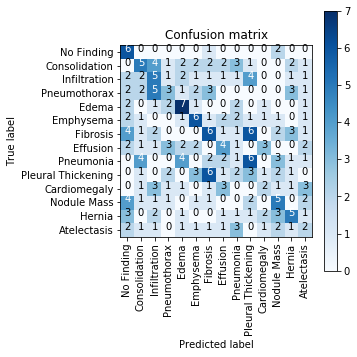

ValueError: Object arrays cannot be loaded when allow_pickle=False

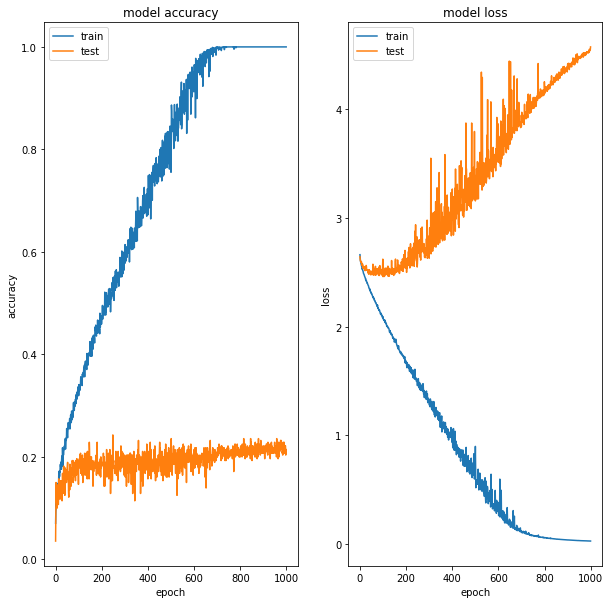

<Figure size 720x360 with 0 Axes>

In [20]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters

with tf.device('/device:GPU:0'):

    def vgg16network(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        base_model = VGG16(weights='imagenet',
            include_top=False, input_shape=(img_size, img_size, 3))
        # Add a new top layer
        x = base_model.output
        x = Flatten()(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.25)(x)
        x = Dense(512, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.0)
                 ,bias_regularizer=keras.regularizers.l2(0.0))(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.5)(x)
        x = Dense(128, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.)
                 ,bias_regularizer=keras.regularizers.l2(0.))(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.5)(x)
        predictions = Dense(num_class, activation='softmax')(x)
        # This is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        # First: train only the top layers (which were randomly initialized)
        for layer in base_model.layers:
            layer.trainable = False
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.SGD(lr=0.005), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b, epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras VGG16 #2 - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1) 
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        return model, history
model, history = vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,1000)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

In [16]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Activation, Dense, Dropout
weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters

with tf.device('/device:GPU:0'):

    def vgg16network(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        base_model = VGG16(weights='imagenet',
            include_top=False, input_shape=(img_size, img_size, 3))
        # Add a new top layer
        x = base_model.output
        x = Flatten()(x)
#         x = Dropout(0.25)(x)
#         x = Dense(512, use_bias=False, activation=None,kernel_regularizer=keras.regularizers.l2(0.00))(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
#         x = Dropout(0.4)(x)
        x = Dense(64, use_bias=False, activation=None,activity_regularizer=keras.regularizers.l2(0.01),
                  kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(num_class, activation='softmax')(x)
        # This is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        # First: train only the top layers (which were randomly initialized)
        for layer in base_model.layers:
            layer.trainable = False
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.SGD(lr=0.0005), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b, epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras VGG16 - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1) 
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        return model, history
model, history = vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,1000)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 79, 79, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 79, 79, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 79, 79, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 39, 39, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 39, 39, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 39, 39, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 19, 19, 128)       0   

Epoch 32/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.3209 - accuracy: 0.1255 - val_loss: 4.2696 - val_accuracy: 0.1214
Epoch 33/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.2294 - accuracy: 0.1592 - val_loss: 4.2615 - val_accuracy: 0.1310
Epoch 34/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.1951 - accuracy: 0.1602 - val_loss: 4.2565 - val_accuracy: 0.1262
Epoch 35/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.2246 - accuracy: 0.1459 - val_loss: 4.2433 - val_accuracy: 0.1286
Epoch 36/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.1982 - accuracy: 0.1408 - val_loss: 4.2380 - val_accuracy: 0.1238
Epoch 37/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.1777 - accuracy: 0.1735 - val_loss: 4.2306 - val_accuracy: 0.1262
Epoch 38/1000
980/980 [==============================] - 8s 8ms/step - loss: 4.2306 - accuracy: 0.1449 - val_loss: 4.2265 - val_ac

980/980 [==============================] - 8s 8ms/step - loss: 3.2510 - accuracy: 0.3704 - val_loss: 3.9113 - val_accuracy: 0.1500
Epoch 145/1000
980/980 [==============================] - 8s 8ms/step - loss: 3.2571 - accuracy: 0.3653 - val_loss: 3.9103 - val_accuracy: 0.1714
Epoch 146/1000
980/980 [==============================] - 8s 8ms/step - loss: 3.1921 - accuracy: 0.3969 - val_loss: 3.9057 - val_accuracy: 0.1643
Epoch 147/1000
980/980 [==============================] - 8s 8ms/step - loss: 3.1977 - accuracy: 0.3857 - val_loss: 3.9021 - val_accuracy: 0.1643
Epoch 148/1000
980/980 [==============================] - 8s 8ms/step - loss: 3.1833 - accuracy: 0.4143 - val_loss: 3.9032 - val_accuracy: 0.1714
Epoch 149/1000
980/980 [==============================] - 8s 8ms/step - loss: 3.1912 - accuracy: 0.3786 - val_loss: 3.9075 - val_accuracy: 0.1571
Epoch 150/1000
980/980 [==============================] - 8s 8ms/step - loss: 3.1763 - accuracy: 0.4082 - val_loss: 3.9027 - val_accuracy: 

980/980 [==============================] - 8s 8ms/step - loss: 2.7102 - accuracy: 0.5327 - val_loss: 3.7992 - val_accuracy: 0.1738
Epoch 257/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.7163 - accuracy: 0.5245 - val_loss: 3.7980 - val_accuracy: 0.1810
Epoch 258/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.6259 - accuracy: 0.5816 - val_loss: 3.8053 - val_accuracy: 0.1810
Epoch 259/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.6723 - accuracy: 0.5490 - val_loss: 3.8001 - val_accuracy: 0.1786
Epoch 260/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.6157 - accuracy: 0.5888 - val_loss: 3.7950 - val_accuracy: 0.1810
Epoch 261/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.6488 - accuracy: 0.5786 - val_loss: 3.7977 - val_accuracy: 0.1762
Epoch 262/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.6746 - accuracy: 0.5633 - val_loss: 3.7980 - val_accuracy: 

980/980 [==============================] - 8s 8ms/step - loss: 2.2654 - accuracy: 0.6959 - val_loss: 3.7245 - val_accuracy: 0.1810
Epoch 369/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.2486 - accuracy: 0.6898 - val_loss: 3.7314 - val_accuracy: 0.1738
Epoch 370/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.2466 - accuracy: 0.7041 - val_loss: 3.7359 - val_accuracy: 0.1762
Epoch 371/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.2848 - accuracy: 0.6796 - val_loss: 3.7332 - val_accuracy: 0.1786
Epoch 372/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.2879 - accuracy: 0.6837 - val_loss: 3.7374 - val_accuracy: 0.1810
Epoch 373/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.2761 - accuracy: 0.6980 - val_loss: 3.7362 - val_accuracy: 0.1786
Epoch 374/1000
980/980 [==============================] - 8s 8ms/step - loss: 2.2802 - accuracy: 0.6806 - val_loss: 3.7354 - val_accuracy: 

980/980 [==============================] - 8s 8ms/step - loss: 1.9629 - accuracy: 0.7827 - val_loss: 3.6909 - val_accuracy: 0.1833
Epoch 481/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.9976 - accuracy: 0.7571 - val_loss: 3.6910 - val_accuracy: 0.1690
Epoch 482/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.9775 - accuracy: 0.7704 - val_loss: 3.6806 - val_accuracy: 0.1810
Epoch 483/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.9875 - accuracy: 0.7776 - val_loss: 3.6906 - val_accuracy: 0.1690
Epoch 484/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.9509 - accuracy: 0.7724 - val_loss: 3.6887 - val_accuracy: 0.1738
Epoch 485/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.9664 - accuracy: 0.8041 - val_loss: 3.6922 - val_accuracy: 0.1738
Epoch 486/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.9324 - accuracy: 0.8020 - val_loss: 3.6843 - val_accuracy: 

980/980 [==============================] - 8s 8ms/step - loss: 1.6992 - accuracy: 0.8449 - val_loss: 3.6560 - val_accuracy: 0.1857
Epoch 593/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.7137 - accuracy: 0.8469 - val_loss: 3.6504 - val_accuracy: 0.1810
Epoch 594/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.7026 - accuracy: 0.8500 - val_loss: 3.6612 - val_accuracy: 0.1857
Epoch 595/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.6960 - accuracy: 0.8388 - val_loss: 3.6511 - val_accuracy: 0.1810
Epoch 596/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.7149 - accuracy: 0.8194 - val_loss: 3.6583 - val_accuracy: 0.1810
Epoch 597/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.7251 - accuracy: 0.8163 - val_loss: 3.6547 - val_accuracy: 0.1786
Epoch 598/1000
980/980 [==============================] - 8s 8ms/step - loss: 1.6804 - accuracy: 0.8551 - val_loss: 3.6529 - val_accuracy: 

980/980 [==============================] - 8s 8ms/step - loss: 1.5220 - accuracy: 0.8918 - val_loss: 3.6419 - val_accuracy: 0.1881
Epoch 705/1000
416/980 [===========>..................] - ETA: 3s - loss: 1.5545 - accuracy: 0.8870

KeyboardInterrupt: 

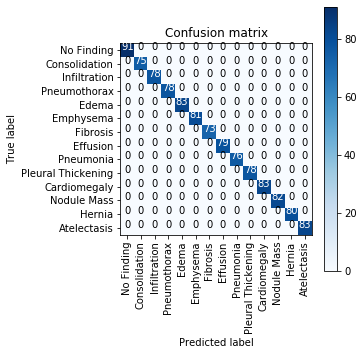

In [21]:
y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_trainHot,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

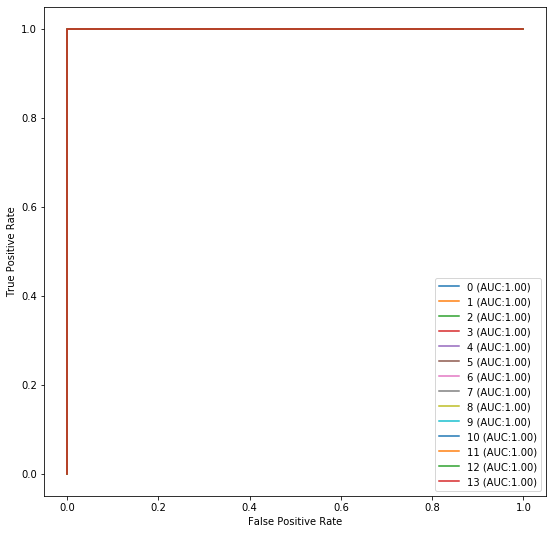

In [22]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
predictions = model.predict(X_train)
for (idx, c_label) in enumerate(map_characters):
    fpr, tpr, thresholds = roc_curve(Y_trainHot[:,idx].astype(int), predictions[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [15]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
# weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
import tensorflow as tf

with tf.device('/device:GPU:0'):

    def ResNet50network(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        base_model = ResNet50(weights='imagenet',
            include_top=False, input_shape=(img_size, img_size, 3))
        # Add a new top layer
        x = base_model.output
#         x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = GlobalAveragePooling2D()(x)
#         x = Flatten()(x)

        x = Dense(128, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.0)
                 ,bias_regularizer=keras.regularizers.l2(0.00))(x)
#         x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(64, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.00)
                 ,bias_regularizer=keras.regularizers.l2(0.00))(x)
#         x = Dense(256, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.005)
#                  ,bias_regularizer=keras.regularizers.l2(0.005))(x)
#         x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(64, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.00)
                 ,bias_regularizer=keras.regularizers.l2(0.00))(x)
#         x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        predictions = Dense(num_class, activation='softmax')(x)
        # This is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        # First: train only the top layers (which were randomly initialized)
        for layer in base_model.layers:
            layer.trainable = False
#         for layer in base_model.layers:
#             print(layer, layer.trainable)

#         checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
#                                      save_weights_only=True, mode='auto', period=1)
        
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.Adam(lr=0.1), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b, epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras ResNet50 - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1) 
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        
        return model, history
model, history = ResNet50network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,10)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

Train on 9343 samples, validate on 2336 samples
Epoch 1/10
9343/9343 [==============================] - 109s 12ms/step - loss: 5.8843 - accuracy: 0.0872 - val_loss: 43.2679 - val_accuracy: 0.0925
Epoch 2/10
9343/9343 [==============================] - 106s 11ms/step - loss: 3.0335 - accuracy: 0.0888 - val_loss: 2.5860 - val_accuracy: 0.0796
Epoch 3/10
9343/9343 [==============================] - 106s 11ms/step - loss: 2.6742 - accuracy: 0.0846 - val_loss: 2.5846 - val_accuracy: 0.0903
Epoch 4/10
4928/9343 [==============>...............] - ETA: 40s - loss: 2.5784 - accuracy: 0.0842

KeyboardInterrupt: 


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 79, 79, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 39, 39, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________


Train on 980 samples, validate on 420 samples
Epoch 1/20
980/980 [==============================] - 39s 39ms/step - loss: 4.0748 - accuracy: 0.0878 - val_loss: 2.9299 - val_accuracy: 0.0643
Epoch 2/20
980/980 [==============================] - 26s 27ms/step - loss: 2.7983 - accuracy: 0.2704 - val_loss: 2.9772 - val_accuracy: 0.0524
Epoch 3/20
980/980 [==============================] - 26s 26ms/step - loss: 2.0566 - accuracy: 0.4255 - val_loss: 3.0132 - val_accuracy: 0.0524
Epoch 4/20
980/980 [==============================] - 26s 26ms/step - loss: 1.7393 - accuracy: 0.5184 - val_loss: 3.0245 - val_accuracy: 0.0524
Epoch 5/20
980/980 [==============================] - 26s 27ms/step - loss: 1.3154 - accuracy: 0.6653 - val_loss: 3.0391 - val_accuracy: 0.0524
Epoch 6/20
980/980 [==============================] - 27s 27ms/step - loss: 1.0924 - accuracy: 0.7378 - val_loss: 3.0674 - val_accuracy: 0.0524
Epoch 7/20
980/980 [==============================] - 26s 27ms/step - loss: 0.7992 - accu

/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



                    precision    recall  f1-score   support

        No Finding       0.00      0.00      0.00        27
     Consolidation       0.00      0.00      0.00        35
      Infiltration       0.00      0.00      0.00        39
      Pneumothorax       0.00      0.00      0.00        37
             Edema       0.00      0.00      0.00        28
         Emphysema       0.06      0.50      0.11        26
          Fibrosis       0.05      0.05      0.05        22
          Effusion       0.00      0.00      0.00        32
         Pneumonia       0.00      0.00      0.00        32
Pleural Thickening       0.00      0.00      0.00        28
      Cardiomegaly       0.11      0.22      0.15        36
       Nodule Mass       0.00      0.00      0.00        27
            Hernia       0.50      0.04      0.07        28
       Atelectasis       0.08      0.35      0.13        23

          accuracy                           0.07       420
         macro avg       0.06      0.

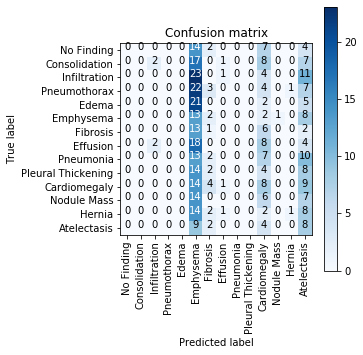

ValueError: Object arrays cannot be loaded when allow_pickle=False

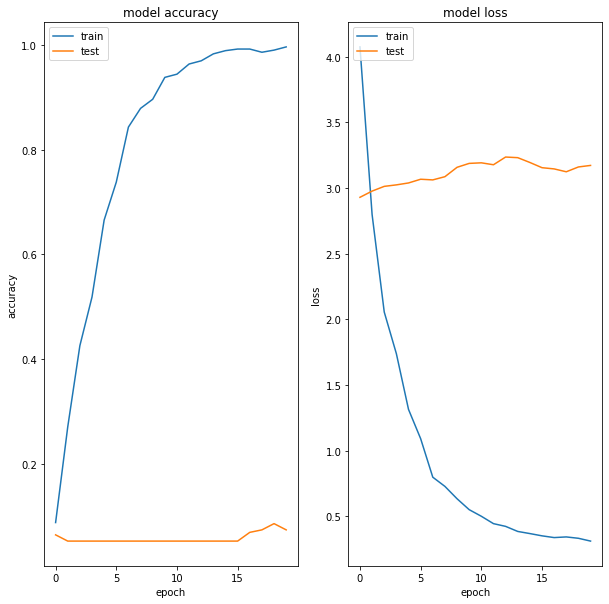

<Figure size 720x360 with 0 Axes>

In [18]:
from keras.applications.xception import Xception
from keras.models import Model
# weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
import tensorflow as tf

with tf.device('/device:GPU:0'):

    def xceptionNet(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        base_model = Xception(weights=None,
            include_top=False, input_shape=(img_size, img_size, 3))
        # Add a new top layer
        x = base_model.output
        x = Flatten()(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.5)(x)
#         x = Dense(512, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001)
#                  ,bias_regularizer=keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001)
                 ,bias_regularizer=keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        predictions = Dense(num_class, activation='softmax')(x)
        # This is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        # First: train only the top layers (which were randomly initialized)
#         for layer in base_model.layers:
#             layer.trainable = False
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.adam(lr=0.0001), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b,epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras Xception #2 - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1)
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        return model, history
model, history = xceptionNet(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,20)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
# weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
import tensorflow as tf

with tf.device('/device:GPU:0'):

    def inceptionNet(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        base_model = InceptionV3(weights='imagenet',
            include_top=False, input_shape=(img_size, img_size, 3))
        # Add a new top layer
        x = base_model.output
        x = Flatten()(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.5)(x)
#         x = Dense(512, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001)
#                  ,bias_regularizer=keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001)
                 ,bias_regularizer=keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        predictions = Dense(num_class, activation='softmax')(x)
        # This is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        # First: train only the top layers (which were randomly initialized)
        for layer in base_model.layers:
            layer.trainable = False
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.adam(lr=0.0001), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b,epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras Xception #2 - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1)
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        return model, history
model, history = inceptionNet(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,500)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

Train on 8175 samples, validate on 3504 samples
Epoch 1/500
8175/8175 [==============================] - 159s 20ms/step - loss: 3.7593 - accuracy: 0.0920 - val_loss: 3.3839 - val_accuracy: 0.0910
Epoch 2/500
8175/8175 [==============================] - 118s 14ms/step - loss: 3.3988 - accuracy: 0.1207 - val_loss: 3.8404 - val_accuracy: 0.0979
Epoch 3/500
8175/8175 [==============================] - 118s 14ms/step - loss: 3.2497 - accuracy: 0.1524 - val_loss: 4.0995 - val_accuracy: 0.1042
Epoch 4/500
8175/8175 [==============================] - 117s 14ms/step - loss: 3.0845 - accuracy: 0.1737 - val_loss: 4.0383 - val_accuracy: 0.0945
Epoch 5/500
8175/8175 [==============================] - 118s 14ms/step - loss: 3.0101 - accuracy: 0.1906 - val_loss: 4.5401 - val_accuracy: 0.0850
Epoch 6/500
8175/8175 [==============================] - 118s 14ms/step - loss: 2.9152 - accuracy: 0.2049 - val_loss: 4.3286 - val_accuracy: 0.0959
Epoch 7/500
8175/8175 [==============================] - 117s 14

In [24]:
from keras.applications.nasnet import NASNetLarge
from keras.models import Model
# weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
import tensorflow as tf

with tf.device('/device:GPU:0'):

    def NasNetwork(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        base_model = NASNetLarge(weights='imagenet',
            include_top=False, input_shape=(img_size, img_size, 3))
        # Add a new top layer
        x = base_model.output
        x = Flatten()(x)
#         x = BatchNormalization()(x)
#         x = Dropout(0.5)(x)
#         x = Dense(512, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001)
#                  ,bias_regularizer=keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001)
                 ,bias_regularizer=keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        predictions = Dense(num_class, activation='softmax')(x)
        # This is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        # First: train only the top layers (which were randomly initialized)
        for layer in base_model.layers:
            layer.trainable = False
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.adam(lr=0.0001), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b,epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras Xception #2 - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1)
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        return model, history
model, history = NasNetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,10)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (331, 331, 3).

In [24]:
from keras.models import Model
# weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
import tensorflow as tf

with tf.device('/device:GPU:0'):

    def LeNet(a,b,c,d,e,f,g):
        num_class = f
        epochs = g
        model = keras.Sequential()

        model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(img_size,img_size,3)))
        model.add(layers.AveragePooling2D())

        model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
        model.add(layers.AveragePooling2D())

        model.add(layers.Flatten())

        model.add(layers.Dense(units=120, activation='relu'))

        model.add(layers.Dense(units=84, activation='relu'))

        model.add(layers.Dense(units=14, activation = 'softmax'))

        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.adam(lr=0.0001), metrics=['accuracy'])
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        model.summary()
        history = model.fit(a,b,epochs=epochs, class_weight=e, 
                            validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
        score = model.evaluate(c,d, verbose=0)
        print('\nKeras LeNet - accuracy:', score[1], '\n')
        y_pred = model.predict(c)
        print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
        Y_pred_classes = np.argmax(y_pred,axis = 1) 
        Y_true = np.argmax(d,axis = 1)
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
        plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
        plt.show()
        return model, history
model, history = NasNetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,10)
plot_learning_curve(history)
plotKerasLearningCurve(history)
plt.show()

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (331, 331, 3).

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)


The imbalance in our dataset has resulted in a biased model.  I tried to prevent this by modifying the class_weights parameter and using in the model.fit function but apparently that was not enough.  Now I will try to compensate for the imbalanced sample size by oversampling or upsampling the minority classes.

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


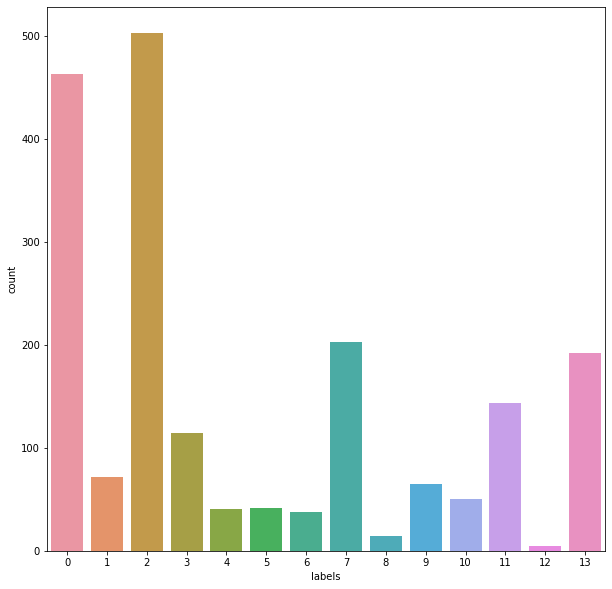

In [23]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

It is very import to do upsampling AFTER the train_test_split function otherwise you can end up with values in the testing dataset that are related to the values within the training dataset.

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [25]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (1556, 64, 64, 3)
X_test Shape:  (390, 64, 64, 3)
X_trainFlat Shape:  (1556, 12288)
X_testFlat Shape:  (390, 12288)


In [26]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 14)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 14)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

X_train:  (1556, 64, 64, 3)
X_trainFlat:  (1556, 12288)
X_trainRos Shape:  (5516, 12288)
X_testRos Shape:  (1526, 12288)
Y_trainRosHot Shape:  (5516, 14)
Y_testRosHot Shape:  (1526, 14)


In [27]:
for i in range(len(X_trainRos)):
    height, width, channels = 64,64,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 64,64,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (5516, 12288)
X_trainRosReshaped Shape:  (5516, 64, 64, 3)
X_testRos Shape:  (1526, 12288)
X_testRosReshaped Shape:  (1526, 64, 64, 3)


{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


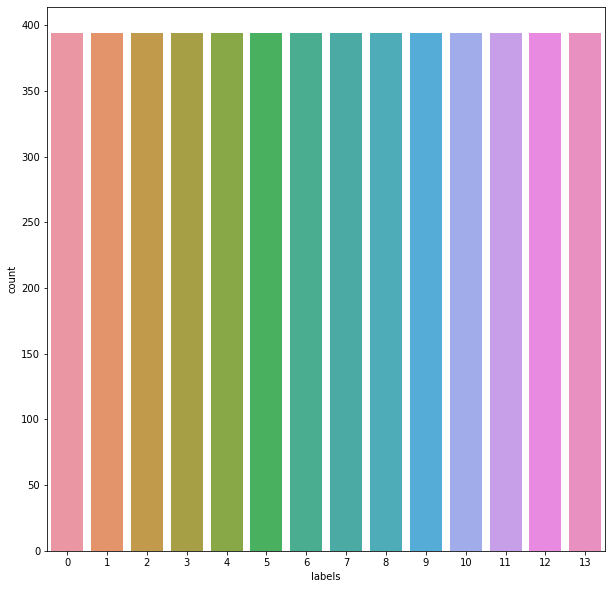

In [28]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

Now we have a much more even distriution of sample sizes for each of our 7 ailments (plus an 8th category for other/typos).  This should help make our model less biased in favor of the majority class (0=No Finding).

In [29]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [ 0.30021598  1.93055556  0.27634195  1.21929825  3.3902439   3.30952381
  3.65789474  0.68472906  9.92857143  2.13846154  2.78        0.96527778
 27.8         0.72395833]
New Class Weights:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Our model can predict pathologies in x-ray images with an accuracy rate that is much better than random chance but there is still a lot of room for improvement.  Please see the [following blogpost](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/) for more detail about specific challenges associated with this dataset . 

In [41]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
weight_path = './keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 64
map_characters=dict_characters  
def ResNet50(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = ResNet50(#weights='imagenet',
        weights = weight_path, include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
ResNet50(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,15)

TypeError: ResNet50() got an unexpected keyword argument 'weights'